# Incorporating fine grained/additional labels with custom loss function in Google Contrail competition

## The competition

[Google Research - Identify Contrails to Reduce Global Warming](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/overview) was hosted on Kaggle and tasked competitors to create a ML model which creates a pixel mask marking contrails on sattelite data.
The images linked here are taken from googles accompanying material.[[1]](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming)[[2]](https://www.kaggle.com/code/inversion/visualizing-contrails)  

![contrails](https://storage.googleapis.com/kaggle-media/competitions/Google-Contrails/waterdroplets.png)

![masks](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F59561%2F590a0bc76044a4ceb71368cf3b62412e%2Fcontrails_600.png?generation=1683669162469942&alt=media)

### Labels

One of the interesting features of the given data was that besides a ground truth mask, additionally the individual masks of each human annotator was given. The ground truth was computed from the individual masks.

> Ground truth was determined by (generally) 4+ different labelers annotating each image. Pixels were considered a contrail when >50% of the labelers annotated it as such. Individual annotations (human_individual_masks.npy) as well as the aggregated ground truth annotations (human_pixel_masks.npy) are included in the training data. The validation data only includes the aggregated ground truth annotations.

The stark differences between each individual mask as well as between the individual masks and the ground truth computed from the masks can easily be seen in an example. 

Ground truth
![ground truth](./pictures/ground_truth.png)
Individual masks
![Individual masks](./pictures/different_masks.png)


### Evaluation metric

> This competition is evaluated on the global Dice coefficient.

## My experiment
Seeing the stark contrast between each individual annotators masks and also between those and the thereof computed ground truth, I felt that including the individual annotators masks should be a big information gain for the model.((((also contrails in ground truth often not semantically useful?BSC-5))))

A simple way to (include this information and still gain knowledge | process the extra information in a meaningful was) seemed to me to punish false positives less if they are present in at least one individual mask. Potentially, this could be combined with punishing false negatives of the ground truth harder as well.
To achive this, I construct the loss funtion from two weighted F-beta-loss functions, one on the ground truth and one on the union of all individual masks, instead of only using the F-1/Dice score on the ground truth mask.  
I then sample loss hyper-parameter values around the values that I expect to perform well.



My goal was to find good hyperparameters for a custom loss function which weighs (i) A F-beta-Score of the ground truth mask with (ii) A F-beta-Score of the Union of the individual masks.

### Ground truth vs union of individual masks




# Show results!!!!
Copy some of the output plots which compares the different hyperparameter of the loss function 

# Code
The code builds upon Egor Trushins' Notebook [[GR-ICRGW] PL Pipeline Improved](https://www.kaggle.com/code/egortrushin/gr-icrgw-pl-pipeline-improved). 

## Segmentation model
I am using [pytorch lightning](https://lightning.ai/pytorch-lightning) and [segmetation_models_pytorch](https://smp.readthedocs.io/en/latest/models.html#unet).  
As segmentation model I use Unet with timm-ResNeSt26d from smp.  
## Data
The given training and validation data is massive.  
Per data-point in the training data set, there are: 
- Satellite images of eight time steps. Four before and three after timesteps, and the timestep the annotators saw.
- Each timestep consists of an satellite image of 9 infrared channels. 
- Four or more individual pixel masks as well as a ground truth mask
Validation data lacks the individual pixel masks, otherwise it's the same.
Instead of utilizing all the infrared bands, I use the rgb ash colour scheme computed from bands 11,13,15 which is also used to show the satellite images to the annotators.

And instead of trying to use all time steps I only use timestep t0.




## Imports

In [1]:
import glob
# import h5py11
import lightning as L
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import segmentation_models_pytorch as smp
import torchvision.transforms as T
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
from torchmetrics.functional import dice
from torch.utils.data import Dataset, DataLoader
import warnings
import yaml
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
# from pprint import pprint

warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')


c:\Users\Albert\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config
The config is used by the dataset and the lightning module to set and load model, trainer and dataset parameters.  
The loss function hyperparameters are saved here as well, but changed via the training function parameter later per model.




In [11]:
%%writefile resnest26d_ash_attention_sample_loss.yaml


output_dir: "./metrics"

seed: 42

train_bs: 68
valid_bs: 128
workers: 6

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 5
    verbose: 1

trainer:
    max_epochs: 30
    min_epochs: 24
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1

model:
    alpha: -1.0
    beta: -1.0
    alpha_union: -1.0
    beta_union: -1.0
    weight_union: -1.0
    weight_ground_truth: -1.0
    seg_model: "Unet"
    encoder_name: "timm-resnest26d"
    encoder_depth: 5
    loss_smooth: 1.0
    decoder_attention_type: "scse"
    image_size: 384
    optimizer_params:
        lr: 0.0005
        weight_decay: 0.0
        eps: 1.0e-6
    scheduler:
        name: "CosineAnnealingLR"
        params:
            CosineAnnealingLR:
                T_max: 2
                eta_min: 1.0e-6
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.31622776601
                patience: 4
                verbose: True


Overwriting resnest26d_ash_attention_sample_loss.yaml


In [ ]:
with open("resnest26d_ash_attention_sample_loss.yaml", "r") as file_obj:
    resnest26d_ash_attention_sample_loss = yaml.safe_load(file_obj)

## Dataset
Because I need all the individual masks for my custom loss function, my Datasets \_\_getitem\_\_ function returns two labels if self.split is "train"

In [ ]:
data_path_mf_train = "/home/albert/ml/Contrails/data/full_dataset/train/"
data_path_mf_valid = "/home/albert/ml/Contrails/data/full_dataset/validation/"

class ContrailsDatasetMixed(Dataset):
    def __init__(self, split="train", mode="single", delta_t = 0):
        self.delta_t = delta_t
        self.split = split
        self.mode = mode
        self.path = (lambda x: data_path_mf_train if x == "train" else data_path_mf_valid)(self.split)
        self.examples = os.listdir(self.path)
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
    def read_record(self, directory):
        record_data = {}
        for x in [
            "band_11", 
            "band_14", 
            "band_15"
        ]:
            record_data[x] = np.load(os.path.join(directory, x + ".npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def get_false_color(self, record_data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        if self.mode == "single":
            t_null = 4
            return false_color[..., t_null+self.delta_t]
        else:
            return false_color
    
    def __getitem__(self, index):
        path = f"{self.path}{self.examples[index]}"
        data = self.read_record(path)    
        img = self.get_false_color(data)
        if self.split == "validation":
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
        if self.split == "train":
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
            label_indiv = np.load(os.path.join(path, "human_individual_masks.npy")).squeeze()
            labelers = label_indiv[1,1,:].shape[0]
            label_union = torch.zeros([256, 256])
            for i in range(labelers):
                label_i = label_indiv[:, :,i]
                label_union[label_i[:, :] == 1] = 1   

        if self.mode == "single":
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1).squeeze()
        else:
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1)

        img = self.normalize_image(img)

        if self.split in ["train"]:
            return img.float(), [label.float(),label_union.float()]
        if self.split in ["validation"]:
            return img.float(), label.float()

        return img.float()
    
    def __len__(self):
        return len(self.examples)

## Lightning Module Custom Tversky Loss
This Lightning module implements the custom loss function.  
The hyperparameters for the loss function are set in the config dictionary, but changed via the training function parameter.

In [ ]:
class LightningModuleTrLoss(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # print(config["aux_params"])
        self.model = model = smp.Unet(
            encoder_name=config["encoder_name"],
            encoder_depth=config["encoder_depth"],
            decoder_channels = (256, 128, 64, 32,16)[:config["encoder_depth"]],
            # aux_params = config["aux_params"],
            decoder_attention_type =config["decoder_attention_type"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []
        self.alpha = config["alpha"]
        self.beta = config["beta"]
        self.alpha_union = config["alpha_union"]
        self.beta_union = config["beta_union"]

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
        elif self.config["scheduler"]["name"] == "cosine_with_hard_restarts_schedule_with_warmup":
            scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}


    def training_step(self, batch, batch_idx):
        imgs, [label_gt,label_union] = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss_ground_truth = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha, beta=self.beta, gamma=1.0)(preds, label_gt)
        loss_union = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha_union, beta=self.beta_union, gamma=1.0)(preds, label_union)
        loss = torch.mul(loss_ground_truth,self.config["weight_ground_truth"])+torch.mul(loss_union, self.config["weight_union"])
        self.log('loss_union', float(loss_union) , on_step=False, on_epoch=True, prog_bar=True) #, batch_size=16
        self.log('loss_ground_truth', float(loss_ground_truth) , on_step=False, on_epoch=True, prog_bar=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

## Function to train the model with certain hyperparamters

The sample_union_loss function can be used to train the model with different hyperparameters. The results are tracked via the csv_logger and can later be plotted to compare the performance of the model on the validation dataset.

In [ ]:
def sample_union_loss(delta, cfg, module,alpha, alpha_union, weight_ground_truth):
    cfg['model']["alpha"] = alpha
    cfg['model']["beta"] = 1-alpha
    cfg['model']["alpha_union"] = alpha_union
    cfg['model']["beta_union"] = 1-alpha_union
    cfg['model']["weight_ground_truth"] = weight_ground_truth
    cfg['model']["weight_union"] = 1-weight_ground_truth
    CHECK WHICH RESNEST I USED AND ADJUST BELOW
    identifier = "resnest26d_alpha="+str(alpha)+"_alpha_union="+str(alpha_union)+"_weight_ground_truth="+str(weight_ground_truth)
    dataset_train = ContrailsDatasetMixed("train", "single",delta)
    dataset_validation = ContrailsDatasetMixed("validation","single", delta)
    
    data_loader_train = DataLoader(
    dataset_train,
    batch_size=cfg["train_bs"],
    shuffle=True,
    num_workers=cfg["workers"],
    )
    
    data_loader_validation = DataLoader(
        dataset_validation,
        batch_size=cfg["valid_bs"],
        shuffle=False,
        num_workers=cfg["workers"],
    )
    
    checkpoint_callback = ModelCheckpoint(
    save_weights_only=True,
    monitor="val_dice",
    dirpath=cfg["output_dir"],
    mode="max",
    filename= identifier,
    save_top_k=1,
    verbose=1,
    )
    
    progress_bar_callback = TQDMProgressBar(
    refresh_rate=cfg["progress_bar_refresh_rate"]
    )

    early_stop_callback = EarlyStopping(**cfg["early_stop"])
    csv_logger = CSVLogger(cfg["output_dir"], name=identifier)
    trainer = L.Trainer(
        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], logger = csv_logger,
        **cfg["trainer"],
    )
    
    # cfg["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"] *= len(data_loader_train)/cfg["trainer"]["devices"]
    model = module(cfg["model"])
    
    trainer.fit(model, data_loader_train, data_loader_validation)
    
    

### Baseline: Dice/F1-Score of Ground truth only

In [ ]:
# Baseline
sample_union_loss(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = 0.5,alpha_union = 0.5, weight_ground_truth = 1)

### Sample tversky parameter and weight

In [ ]:
for weight_ground_truth in [0.6,0.7]:
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            # sample_union_loss(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)

In [ ]:
TODO
# Organize the metrics/ copy them into this folder such that they can be uploaded to github



alpha=0.35_alpha_union=0.4_weight_ground_truth=0.6 max: 0.607
alpha=0.35_alpha_union=0.6_weight_ground_truth=0.6 max: 0.612
alpha=0.35_alpha_union=0.8_weight_ground_truth=0.6 max: 0.614
alpha=0.5_alpha_union=0.4_weight_ground_truth=0.6 max: 0.616
alpha=0.5_alpha_union=0.6_weight_ground_truth=0.6 max: 0.623
alpha=0.5_alpha_union=0.8_weight_ground_truth=0.6 max: 0.625
alpha=0.65_alpha_union=0.4_weight_ground_truth=0.6 max: 0.615
alpha=0.65_alpha_union=0.6_weight_ground_truth=0.6 max: 0.619
alpha=0.65_alpha_union=0.8_weight_ground_truth=0.6 max: 0.616


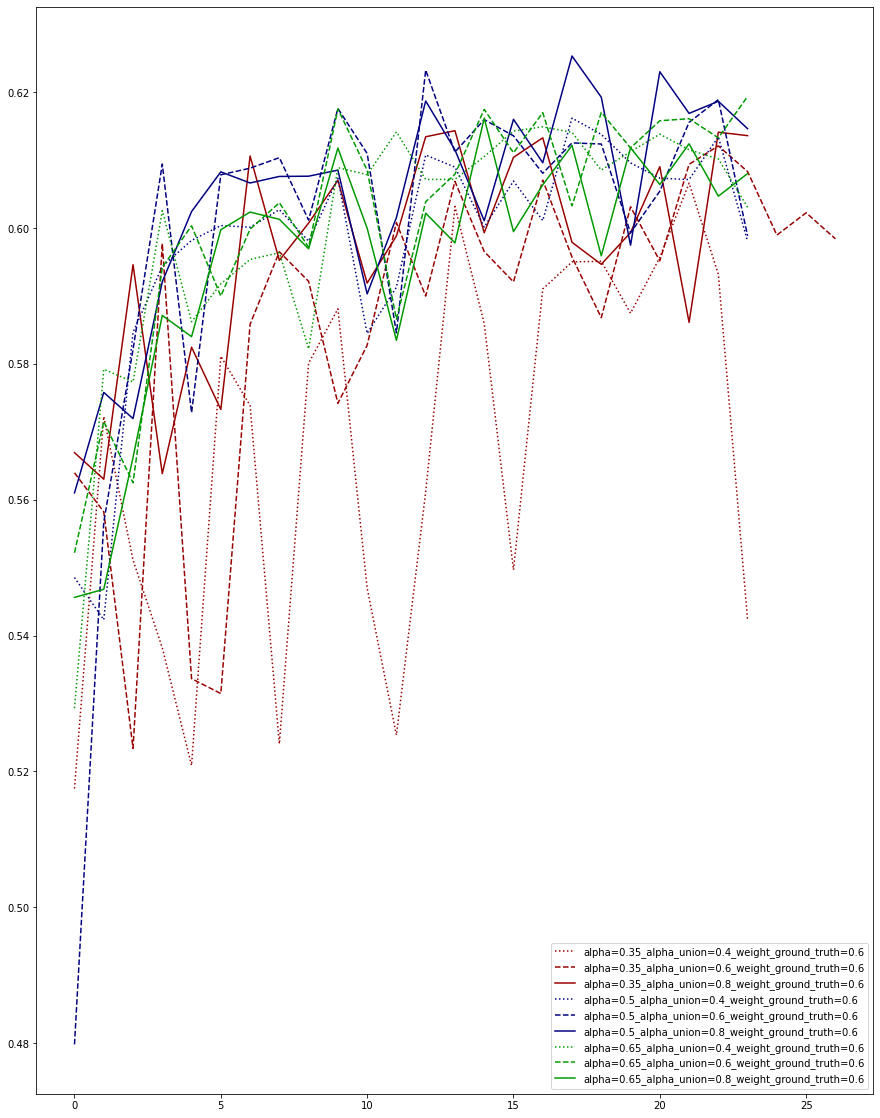

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(15,20))
for weight_ground_truth in [0.6]:
    print("")
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            linestyle = {0.4:"dotted",0.6:"--",0.8:"-"}[alpha_union]
            color = {0.35:(0.6,0,0),0.5:(0,0,0.5),0.65:(0, 0.6, 0)}[alpha]
            plt.plot(metrics['val_dice'], label=label, linestyle = linestyle, color = color)
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            print(label + " max: {:.3f}".format(maximum))
plt.legend()
plt.show()


alpha=0.35_alpha_union=0.4_weight_ground_truth=0.7 max: 0.612
alpha=0.35_alpha_union=0.6_weight_ground_truth=0.7 max: 0.613
alpha=0.35_alpha_union=0.8_weight_ground_truth=0.7 max: 0.613
alpha=0.5_alpha_union=0.4_weight_ground_truth=0.7 max: 0.615
alpha=0.5_alpha_union=0.6_weight_ground_truth=0.7 max: 0.619
alpha=0.5_alpha_union=0.8_weight_ground_truth=0.7 max: 0.616
alpha=0.65_alpha_union=0.4_weight_ground_truth=0.7 max: 0.610
alpha=0.65_alpha_union=0.6_weight_ground_truth=0.7 max: 0.619
alpha=0.65_alpha_union=0.8_weight_ground_truth=0.7 max: 0.615


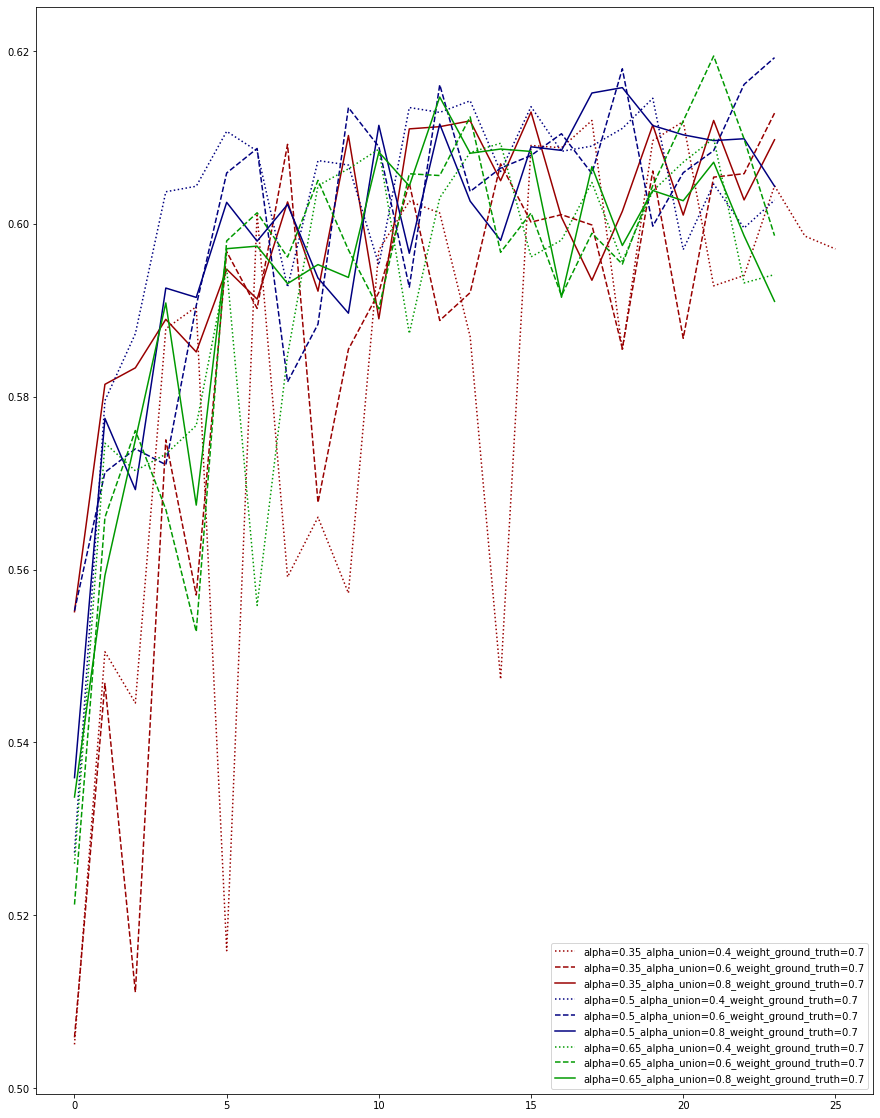

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(15,20))
for weight_ground_truth in [0.7]:
    print("")
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            linestyle = {0.4:"dotted",0.6:"--",0.8:"-"}[alpha_union]
            color = {0.35:(0.6,0,0),0.5:(0,0,0.5),0.65:(0, 0.6, 0)}[alpha]
            plt.plot(metrics['val_dice'], label=label, linestyle = linestyle, color = color)
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            print(label + " max: {:.3f}".format(maximum))
plt.legend()
plt.show()

Here it seems like the model 0.5 0.6 0.7 seems to continue to improve

# TODO: 
Add below graphs and then check what I continued to explore, and reason for that

 max: 0.612 alpha=0.35_alpha_union=0.4_weight_ground_truth=0.7
 max: 0.613 alpha=0.35_alpha_union=0.6_weight_ground_truth=0.7
 max: 0.613 alpha=0.35_alpha_union=0.8_weight_ground_truth=0.7
 max: 0.615 alpha=0.5_alpha_union=0.4_weight_ground_truth=0.7
 max: 0.619 alpha=0.5_alpha_union=0.6_weight_ground_truth=0.7
 max: 0.616 alpha=0.5_alpha_union=0.8_weight_ground_truth=0.7
 max: 0.610 alpha=0.65_alpha_union=0.4_weight_ground_truth=0.7
 max: 0.619 alpha=0.65_alpha_union=0.6_weight_ground_truth=0.7
 max: 0.615 alpha=0.65_alpha_union=0.8_weight_ground_truth=0.7


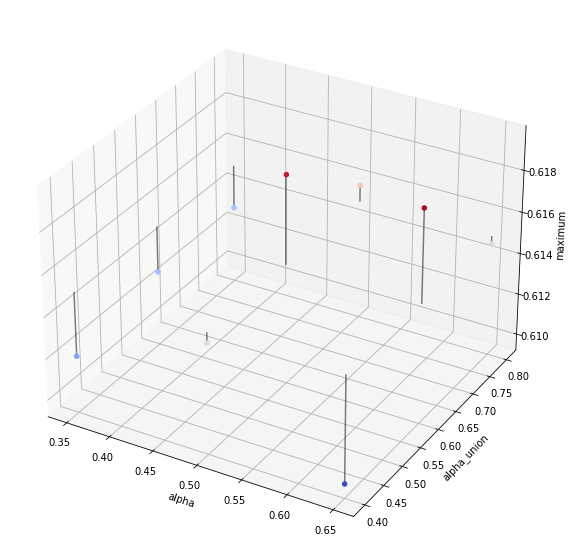

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np


data = []
dice_list = []
for weight_ground_truth in [0.7]:
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            label = f"alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
            data.append([alpha, alpha_union, maximum])
            dice_list.append(f" max: {maximum:.3f} "+label)

dice_list.sort
for element in dice_list: print(element)

import matplotlib.pyplot as plt

x = [i[0] for i in data]
y = [i[1] for i in data]
z = [i[2] for i in data]

# plt.figure(figsize=(15,15))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid
X,Y = np.meshgrid(x,y)

# Interpolate the data
from scipy.interpolate import griddata
Z = griddata((x,y), z, (X,Y), method='cubic')

# Plot the points with a color gradient
ax.scatter(x,y,z,c=z,cmap='coolwarm', alpha=1)

# Add a color bar which maps values to colors
# fig.colorbar(surf)

# Plot lines from points to surface
for i in range(len(x)):
    ax.plot([x[i], x[i]], [y[i], y[i]], [0.615, z[i]], color='black', alpha=0.5)

# Plot the surface
ax.set_xlabel('alpha')
ax.set_ylabel('alpha_union')
ax.set_zlabel('maximum')

plt.show()

Fst Conclusion



In [ ]:
Check to see which config I used in my results!!!

Train the model

In [ ]:
for weight_ground_truth in [0.6,0.7,0.8]:
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            sample_union_loss(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)
            

In [ ]:
plot individual masks of specific example